In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [ ]:
!pip install pymysql
import sqlalchemy
from sqlalchemy.sql import text
from urllib.parse import quote_plus

engine = sqlalchemy.create_engine("mysql+pymysql://root:%s@34.141.168.80/growrain" % quote_plus("Jinsha@15535!"))
query1 = '''SELECT Latitude, Longitude, Time, SoilMoisture, Percipitation from PredictRain;'''
with engine.connect().execution_options(autocommit=True) as con:
    rs1 = con.execute(text(query1))

raw_df = pd.DataFrame(rs1.fetchall())
raw_df = raw_df.reset_index()
raw_df = raw_df.drop('index', axis=1)
raw_df = raw_df.rename(columns={0:'Latitude',1:'Longitude',2:'Time',3:'SoilMoisture',4:'Percipitation'})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 1.6 MB/s eta 0:00:00


<ipython-input-2-f03c08b3aded>:9: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  rs1 = con.execute(text(query1))


In [ ]:
raw_df

,Latitude,Longitude,Time,SoilMoisture,Percipitation
0,0.000,0.000,2017-09-05 09:00:00,0.000000,0.03
1,0.000,0.000,2017-09-05 10:00:00,0.141852,0.02
2,0.000,0.000,2017-09-05 11:00:00,0.283214,0.02
3,0.000,0.000,2017-09-05 12:00:00,0.217857,0.02
4,0.000,0.000,2017-09-05 13:00:00,0.263571,0.02
...,...,...,...,...,...
750569,56.752,-3.542,2019-07-05 13:00:00,0.000000,0.49
750570,56.752,-3.542,2019-07-05 14:00:00,0.000000,0.27
750571,56.752,-3.542,2019-07-05 15:00:00,0.000000,0.19
750572,56.752,-3.542,2019-07-05 16:00:00,0.000000,0.14


In [ ]:
def setLocation(Lat,Lon):
   df =  raw_df[(raw_df['Latitude'] == Lat) 
                & (raw_df['Longitude'] == Lon)]
   df =  df.drop('Latitude', axis=1)
   df =  df.drop('Longitude', axis=1)
   df.index = pd.to_datetime(df['Time'],
                             format='%Y-%m-%d %H:%M:%S')
   return df

In [ ]:
df = setLocation(56.457,-2.976)

rain = df[['Percipitation','SoilMoisture']]      #.apply(lambda x: x*100)
rain


,Percipitation,SoilMoisture
Time,,
2018-05-30 20:00:00,0.00,26.425000
2018-05-30 21:00:00,0.01,26.590000
2018-05-30 22:00:00,0.01,26.727500
2018-05-30 23:00:00,0.01,26.489999
2018-05-31 00:00:00,0.03,26.582500
...,...,...
2019-06-08 07:00:00,0.24,35.042500
2019-06-08 08:00:00,0.21,35.015000
2019-06-08 09:00:00,0.26,34.957500


In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(rain)
X1.shape, y1.shape

((2314, 6, 2), (2314,))

In [ ]:
n1 = round((X1.shape[0]*70)/100)
n2 = n1 + round((X1.shape[0]*20)/100)

X_train1, y_train1 = X1[:n1], y1[:n1]
X_val1, y_val1 = X1[n1:n2], y1[n1:n2]
X_test1, y_test1 = X1[n2:], y1[n2:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1620, 6, 2), (1620,), (463, 6, 2), (463,), (231, 6, 2), (231,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((6, 2)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'accuracy'])

In [ ]:
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
49/51 [===========================>..] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3506 - accuracy: 0.2494

51/51 [==============================] - 9s 127ms/step - loss: 0.1221 - root_mean_squared_error: 0.3495 - accuracy: 0.2519 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2550 - val_accuracy: 0.5119
Epoch 2/50
50/51 [============================>.] - ETA: 0s - loss: 0.1105 - root_mean_squared_error: 0.3324 - accuracy: 0.2512

51/51 [==============================] - 5s 101ms/step - loss: 0.1098 - root_mean_squared_error: 0.3313 - accuracy: 0.2519 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2523 - val_accuracy: 0.5119
Epoch 3/50
51/51 [==============================] - 0s 8ms/step - loss: 0.1083 - root_mean_squared_error: 0.3291 - accuracy: 0.2519 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2554 - val_accuracy: 0.5119
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1074 - root_mean_squared_error: 0.3277 - accuracy: 0.2519 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2537 - val_accuracy: 0.5119
Epoch 5/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0967 - root_mean_squared_error: 0.3109 - accuracy: 0.2526

51/51 [==============================] - 6s 116ms/step - loss: 0.1059 - root_mean_squared_error: 0.3254 - accuracy: 0.2519 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2505 - val_accuracy: 0.5119
Epoch 6/50
50/51 [============================>.] - ETA: 0s - loss: 0.1056 - root_mean_squared_error: 0.3249 - accuracy: 0.2500

51/51 [==============================] - 5s 92ms/step - loss: 0.1044 - root_mean_squared_error: 0.3231 - accuracy: 0.2519 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2492 - val_accuracy: 0.5119
Epoch 7/50
51/51 [==============================] - 0s 8ms/step - loss: 0.1036 - root_mean_squared_error: 0.3218 - accuracy: 0.2519 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2513 - val_accuracy: 0.5119
Epoch 8/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1019 - root_mean_squared_error: 0.3192 - accuracy: 0.2519 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2511 - val_accuracy: 0.5119
Epoch 9/50
50/51 [============================>.] - ETA: 0s - loss: 0.1012 - root_mean_squared_error: 0.3181 - accuracy: 0.2506

51/51 [==============================] - 6s 120ms/step - loss: 0.1008 - root_mean_squared_error: 0.3174 - accuracy: 0.2519 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2460 - val_accuracy: 0.5119
Epoch 10/50
47/51 [==========================>...] - ETA: 0s - loss: 0.1046 - root_mean_squared_error: 0.3234 - accuracy: 0.2487

51/51 [==============================] - 5s 93ms/step - loss: 0.0990 - root_mean_squared_error: 0.3147 - accuracy: 0.2519 - val_loss: 0.0585 - val_root_mean_squared_error: 0.2418 - val_accuracy: 0.5119
Epoch 11/50
50/51 [============================>.] - ETA: 0s - loss: 0.0985 - root_mean_squared_error: 0.3139 - accuracy: 0.2500

51/51 [==============================] - 5s 106ms/step - loss: 0.0977 - root_mean_squared_error: 0.3125 - accuracy: 0.2519 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417 - val_accuracy: 0.5119
Epoch 12/50
49/51 [===========================>..] - ETA: 0s - loss: 0.0973 - root_mean_squared_error: 0.3119 - accuracy: 0.2545

51/51 [==============================] - 5s 108ms/step - loss: 0.0960 - root_mean_squared_error: 0.3099 - accuracy: 0.2519 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2396 - val_accuracy: 0.5119
Epoch 13/50
51/51 [==============================] - 0s 8ms/step - loss: 0.0924 - root_mean_squared_error: 0.3039 - accuracy: 0.2519 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2400 - val_accuracy: 0.5119
Epoch 14/50
49/51 [===========================>..] - ETA: 0s - loss: 0.0899 - root_mean_squared_error: 0.2999 - accuracy: 0.2506

51/51 [==============================] - 5s 104ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - accuracy: 0.2519 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2371 - val_accuracy: 0.5119
Epoch 15/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0879 - root_mean_squared_error: 0.2965 - accuracy: 0.2561

51/51 [==============================] - 6s 111ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - accuracy: 0.2519 - val_loss: 0.0508 - val_root_mean_squared_error: 0.2254 - val_accuracy: 0.5119
Epoch 16/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0823 - root_mean_squared_error: 0.2870 - accuracy: 0.2526

51/51 [==============================] - 5s 105ms/step - loss: 0.0824 - root_mean_squared_error: 0.2871 - accuracy: 0.2519 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2196 - val_accuracy: 0.5119
Epoch 17/50
47/51 [==========================>...] - ETA: 0s - loss: 0.0815 - root_mean_squared_error: 0.2855 - accuracy: 0.2520

51/51 [==============================] - 5s 109ms/step - loss: 0.0790 - root_mean_squared_error: 0.2811 - accuracy: 0.2519 - val_loss: 0.0469 - val_root_mean_squared_error: 0.2167 - val_accuracy: 0.5119
Epoch 18/50
51/51 [==============================] - 1s 11ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - accuracy: 0.2519 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2234 - val_accuracy: 0.5119
Epoch 19/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0730 - root_mean_squared_error: 0.2702 - accuracy: 0.2546

51/51 [==============================] - 5s 105ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - accuracy: 0.2525 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2082 - val_accuracy: 0.5119
Epoch 20/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0676 - root_mean_squared_error: 0.2600 - accuracy: 0.2595

51/51 [==============================] - 5s 96ms/step - loss: 0.0692 - root_mean_squared_error: 0.2631 - accuracy: 0.2525 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1989 - val_accuracy: 0.5119
Epoch 21/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0653 - root_mean_squared_error: 0.2556 - accuracy: 0.2507

51/51 [==============================] - 6s 118ms/step - loss: 0.0664 - root_mean_squared_error: 0.2577 - accuracy: 0.2525 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950 - val_accuracy: 0.5119
Epoch 22/50
50/51 [============================>.] - ETA: 0s - loss: 0.0655 - root_mean_squared_error: 0.2559 - accuracy: 0.2519

51/51 [==============================] - 5s 93ms/step - loss: 0.0647 - root_mean_squared_error: 0.2545 - accuracy: 0.2525 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1922 - val_accuracy: 0.5119
Epoch 23/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0644 - root_mean_squared_error: 0.2538 - accuracy: 0.2507

51/51 [==============================] - 6s 120ms/step - loss: 0.0616 - root_mean_squared_error: 0.2481 - accuracy: 0.2525 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1864 - val_accuracy: 0.5119
Epoch 24/50
51/51 [==============================] - 0s 8ms/step - loss: 0.0600 - root_mean_squared_error: 0.2449 - accuracy: 0.2525 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916 - val_accuracy: 0.5119
Epoch 25/50
51/51 [==============================] - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.2413 - accuracy: 0.2525

51/51 [==============================] - 5s 94ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - accuracy: 0.2525 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1803 - val_accuracy: 0.5119
Epoch 26/50
47/51 [==========================>...] - ETA: 0s - loss: 0.0589 - root_mean_squared_error: 0.2428 - accuracy: 0.2533

51/51 [==============================] - 6s 120ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366 - accuracy: 0.2525 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1769 - val_accuracy: 0.5119
Epoch 27/50
45/51 [=========================>....] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2244 - accuracy: 0.2618

51/51 [==============================] - 5s 97ms/step - loss: 0.0542 - root_mean_squared_error: 0.2329 - accuracy: 0.2525 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750 - val_accuracy: 0.5119
Epoch 28/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0544 - root_mean_squared_error: 0.2333 - accuracy: 0.2520

51/51 [==============================] - 6s 115ms/step - loss: 0.0529 - root_mean_squared_error: 0.2299 - accuracy: 0.2525 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709 - val_accuracy: 0.5119
Epoch 29/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254 - accuracy: 0.2525 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758 - val_accuracy: 0.5119
Epoch 30/50
50/51 [============================>.] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.2250 - accuracy: 0.2525

51/51 [==============================] - 5s 101ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237 - accuracy: 0.2525 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656 - val_accuracy: 0.5119
Epoch 31/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 0.2081 - accuracy: 0.2534

51/51 [==============================] - 5s 109ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - accuracy: 0.2525 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1622 - val_accuracy: 0.5119
Epoch 32/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.2137 - accuracy: 0.2507

51/51 [==============================] - 6s 113ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - accuracy: 0.2525 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590 - val_accuracy: 0.5119
Epoch 33/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.2197 - accuracy: 0.2500

51/51 [==============================] - 5s 106ms/step - loss: 0.0448 - root_mean_squared_error: 0.2117 - accuracy: 0.2525 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1560 - val_accuracy: 0.5119
Epoch 34/50
46/51 [==========================>...] - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.2035 - accuracy: 0.2480

51/51 [==============================] - 6s 110ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - accuracy: 0.2525 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541 - val_accuracy: 0.5119
Epoch 35/50
44/51 [========================>.....] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2045 - accuracy: 0.2500

51/51 [==============================] - 5s 109ms/step - loss: 0.0416 - root_mean_squared_error: 0.2041 - accuracy: 0.2525 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517 - val_accuracy: 0.5119
Epoch 36/50
51/51 [==============================] - ETA: 0s - loss: 0.0406 - root_mean_squared_error: 0.2014 - accuracy: 0.2525

51/51 [==============================] - 6s 113ms/step - loss: 0.0406 - root_mean_squared_error: 0.2014 - accuracy: 0.2525 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491 - val_accuracy: 0.5119
Epoch 37/50
47/51 [==========================>...] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2044 - accuracy: 0.2513

51/51 [==============================] - 5s 109ms/step - loss: 0.0394 - root_mean_squared_error: 0.1986 - accuracy: 0.2525 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490 - val_accuracy: 0.5119
Epoch 38/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 0.1956 - accuracy: 0.2604

51/51 [==============================] - 5s 94ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - accuracy: 0.2525 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1461 - val_accuracy: 0.5119
Epoch 39/50
50/51 [============================>.] - ETA: 0s - loss: 0.0379 - root_mean_squared_error: 0.1947 - accuracy: 0.2525

51/51 [==============================] - 6s 119ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - accuracy: 0.2525 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432 - val_accuracy: 0.5119
Epoch 40/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0324 - root_mean_squared_error: 0.1800 - accuracy: 0.2552

51/51 [==============================] - 5s 104ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908 - accuracy: 0.2525 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413 - val_accuracy: 0.5119
Epoch 41/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0354 - root_mean_squared_error: 0.1883 - accuracy: 0.2525 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1454 - val_accuracy: 0.5119
Epoch 42/50
48/51 [===========================>..] - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.1863 - accuracy: 0.2520

51/51 [==============================] - 6s 110ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - accuracy: 0.2525 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381 - val_accuracy: 0.5119
Epoch 43/50
45/51 [=========================>....] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1776 - accuracy: 0.2549

51/51 [==============================] - 5s 110ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - accuracy: 0.2525 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1363 - val_accuracy: 0.5119
Epoch 44/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0330 - root_mean_squared_error: 0.1816 - accuracy: 0.2525 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375 - val_accuracy: 0.5119
Epoch 45/50
50/51 [============================>.] - ETA: 0s - loss: 0.0328 - root_mean_squared_error: 0.1812 - accuracy: 0.2531

51/51 [==============================] - 5s 110ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - accuracy: 0.2525 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338 - val_accuracy: 0.5119
Epoch 46/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0319 - root_mean_squared_error: 0.1787 - accuracy: 0.2525 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340 - val_accuracy: 0.5119
Epoch 47/50
51/51 [==============================] - 0s 8ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755 - accuracy: 0.2525 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386 - val_accuracy: 0.5119
Epoch 48/50
47/51 [==========================>...] - ETA: 0s - loss: 0.0308 - root_mean_squared_error: 0.1755 - accuracy: 0.2586

51/51 [==============================] - 5s 105ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748 - accuracy: 0.2525 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308 - val_accuracy: 0.5119
Epoch 49/50
51/51 [==============================] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.1731 - accuracy: 0.2525

51/51 [==============================] - 6s 113ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - accuracy: 0.2525 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1294 - val_accuracy: 0.5119
Epoch 50/50
50/51 [============================>.] - ETA: 0s - loss: 0.0297 - root_mean_squared_error: 0.1722 - accuracy: 0.2506

51/51 [==============================] - 5s 107ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713 - accuracy: 0.2525 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286 - val_accuracy: 0.5119


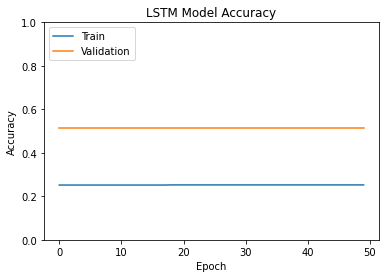

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim([0, 1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

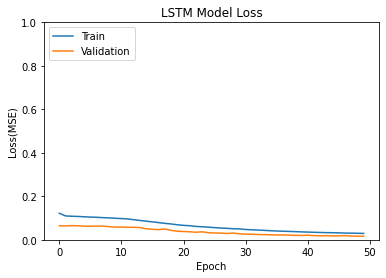

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
plt.plot(history.history['loss'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('LSTM Model Error')
plt.ylabel('Error(MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

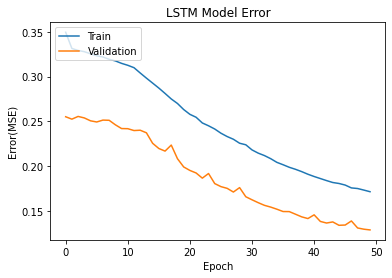

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('LSTM Model Error')
plt.ylabel('Error(MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

51/51 [==============================] - 1s 3ms/step


,Train Predictions,Actuals
0,0.026276,0.09
1,0.041146,0.14
2,0.078271,0.16
3,0.109496,0.15
4,0.115867,0.14
...,...,...
1615,0.024266,0.00
1616,0.024886,0.00
1617,0.025259,0.00
1618,0.025845,0.00


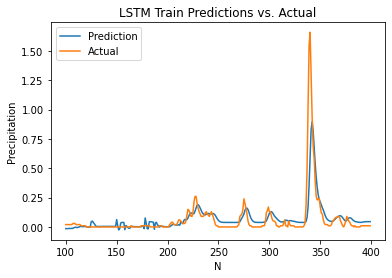

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][100:400])
plt.plot(train_results['Actuals'][100:400])
plt.title('LSTM Train Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

15/15 [==============================] - 0s 3ms/step


,Val Predictions,Actuals
0,0.032676,0.02
1,0.040889,0.06
2,0.066849,0.07
3,0.078179,0.09
4,0.094128,0.09
...,...,...
458,-0.027036,0.00
459,-0.017829,0.00
460,-0.016580,0.01
461,-0.013798,0.00


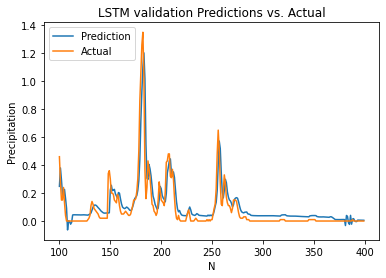

In [ ]:
plt.plot(val_results['Val Predictions'][100:400])
plt.plot(val_results['Actuals'][100:400])
plt.title('LSTM validation Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

8/8 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,0.002183,0.00
1,0.002157,0.00
2,0.002245,0.00
3,0.002248,0.00
4,0.001894,0.00
...,...,...
226,0.292542,0.24
227,0.270845,0.21
228,0.248783,0.26
229,0.278935,0.32


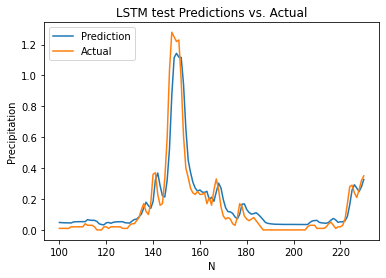

In [ ]:
plt.plot(test_results['Test Predictions'][100:400])
plt.plot(test_results['Actuals'][100:400])
plt.title('LSTM test Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')